# Identifying spam e-mails with neural networks

A common use for binary classification is sorting spam e-mails from legitimate e-mails. It's not difficult to build a neural network that classifies text. Let's use Keras to build a binary classifier for e-mails, train it with a collection of e-mails labeled with 0s (for not spam) and 1s (for spam), and then run a few e-mails through it to see how well it performs.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in deep learning. We'll use Keras's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to vectorize the text in the training e-mails, and we'll get some help from the [Natural Language Toolkit](https://www.nltk.org/) for removing stop words.

In [1]:
import pandas as pd

df = pd.read_csv('Data/ham-spam.csv')
df.head()

,IsSpam,Text
0,0,key issues going forwarda year end reviews rep...
1,0,congrats contratulations the execution the cen...
2,0,key issues going forwardall under control set...
3,0,epmi files protest entergy transcoattached our...
4,0,california power please contact kristin walsh ...


Find out how many rows the dataset contains and confirm that there are no missing values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   IsSpam  1000 non-null   int64 
 1   Text    1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


Remove duplicate rows from the dataset and check for balance.

In [3]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  summary points cdwrattached please find some n...    1
1        500    500  hidear sir madam engr munachim eze chairman th...    1

Create a feature column *x* containing the text in the "Text" column with stopwords removed, and a label column *y*.

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
x = df.apply(lambda row: remove_stop_words(row['Text']), axis=1)
y = df['IsSpam']

Tokenize the text and create padded sequences from it.

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 20000
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

## Train a neural network to identify spam

Create a neural network containing an [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors and a [`Dense`](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding

model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           640000    
_________________________________________________________________
flatten (Flatten)            (None, 16000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2048128   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,688,257
Trainable params: 2,688,257
Non-trainable params: 0
_________________________________________________________________


Train the network.

In [7]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 [==============================] - 8s 15ms/step - loss: 0.6778 - accuracy: 0.6391 - val_loss: 0.7083 - val_accuracy: 0.5900
Epoch 2/5
40/40 [==============================] - 0s 8ms/step - loss: 0.4587 - accuracy: 0.8197 - val_loss: 0.4924 - val_accuracy: 0.9050
Epoch 3/5
40/40 [==============================] - 0s 8ms/step - loss: 0.1467 - accuracy: 0.9916 - val_loss: 0.3130 - val_accuracy: 0.9350
Epoch 4/5
40/40 [==============================] - 0s 8ms/step - loss: 0.0427 - accuracy: 0.9880 - val_loss: 0.1308 - val_accuracy: 0.9750
Epoch 5/5
40/40 [==============================] - 0s 8ms/step - loss: 0.0186 - accuracy: 0.9963 - val_loss: 0.1083 - val_accuracy: 0.9700


Chart the training and validation accuracy for each epoch.

[]

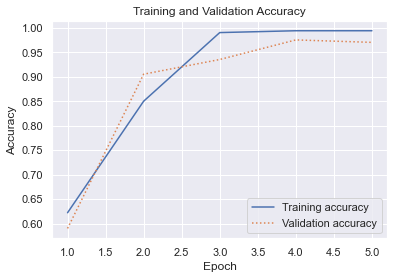

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Train a convolutional neural network to identify spam

Convolutional neural networks (CNNs) are primarily used to classify images, but they can be helpful for text classification, too. One advantage to a CNN is that it can recognize word patterns and factor them into its predictions rather than treat words independently. Let's train a CNN and see if it can achieve a higher validation accuracy than a conventional neural network.

In [9]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           640000    
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 654,433
Trainable params: 654,433
Non-trainable params: 0
________________________________________________

Train the network.

In [10]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 [==============================] - 2s 14ms/step - loss: 0.6786 - accuracy: 0.5844 - val_loss: 0.9463 - val_accuracy: 0.0000e+00
Epoch 2/5
40/40 [==============================] - 0s 9ms/step - loss: 0.5787 - accuracy: 0.6234 - val_loss: 0.8060 - val_accuracy: 0.0950
Epoch 3/5
40/40 [==============================] - 0s 9ms/step - loss: 0.3418 - accuracy: 0.8284 - val_loss: 0.4021 - val_accuracy: 0.9500
Epoch 4/5
40/40 [==============================] - 0s 9ms/step - loss: 0.1180 - accuracy: 0.9715 - val_loss: 0.1440 - val_accuracy: 0.9900
Epoch 5/5
40/40 [==============================] - 0s 9ms/step - loss: 0.0358 - accuracy: 0.9917 - val_loss: 0.0852 - val_accuracy: 0.9900


Chart the training and validation accuracy for each epoch.

[]

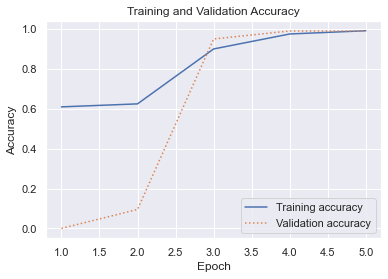

In [11]:
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to classify e-mails

Now let's see how the model classifies some sample e-mails. We'll start with a message that is not spam. The model's `predict` method predicts the probability that the input belongs to the positive class (spam).

In [12]:
cleaned_text = remove_stop_words('Can you attend a code review on Tuesday? Need to make sure the logic is rock solid.')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.32004166

Now test the model with a spam message.

In [13]:
cleaned_text = remove_stop_words('Why pay more for expensive meds when you can order them online and save $$$?')
sequence = tokenizer.texts_to_sequences([cleaned_text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

0.7966199